# Daily precipitation regimes
Here we explore the variability in the distribution of daily precipitation accumulations

In [117]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import pandas as pd
import numpy as np
from src.regions import *
from src.daily import *
from src.plotting import *
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
pr = load_merged_cmorph_daily()
crh = load_merged_era5_daily_crh()

Text(0, 0.5, 'CMORPH Daily 1x1 Precip [mm/d]')

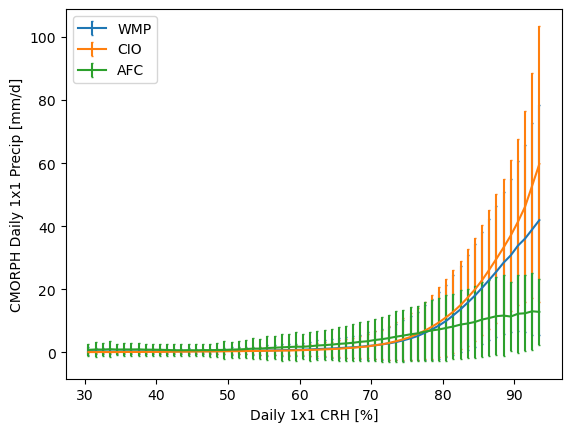

In [129]:
fig, ax = plt.subplots()
for region in [wmp_region(), cio_region(), afc_region()]:
    crh_reg = crh.where(pr > 0, np.nan).sel(region.get_slices())
    pr_reg = pr.where(pr > 0, np.nan).sel(region.get_slices())
    crh_aligned, pr_aligned = xr.align(crh_reg, pr_reg, join='inner')
    crh_bins = np.arange(30, 95, 1)
    
    # Compute mean and standard deviation within each CRH bin
    grouped_pr = pr_aligned.groupby_bins(crh_aligned, bins=crh_bins)
    pr_mean = grouped_pr.mean()
    pr_std = grouped_pr.std()
    
    # Calculate CRH bin midpoints for x-axis plotting
    crh_midpoints = (crh_bins[1:] + crh_bins[:-1]) / 2
    
    # Plot the mean with error bars for ±1 std deviation
    ax.errorbar(crh_midpoints, pr_mean, yerr=pr_std, label=region.name, capsize=1, alpha=1)

ax.legend(loc='upper left')
ax.set_xlabel('Daily 1x1 CRH [%]')
ax.set_ylabel('CMORPH Daily 1x1 Precip [mm/d]')


So now we ask: given some daily CRH or daily precip amount, what does the distribution of system size and intesities look like?

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_25679/488480131.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_grouped = pf_data.groupby('crh_binned')['data_to_plot']
/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_25679/488480131.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_grouped = pf_data.groupby('crh_binned')['data_to_plot']
/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_25679/488480131.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current beh

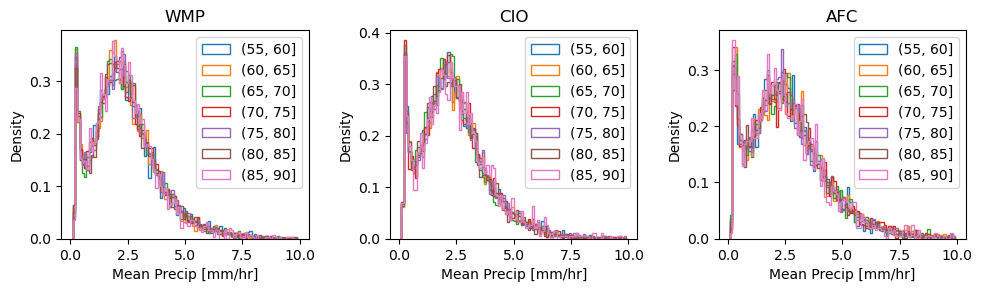

In [141]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 3))

for region, ax in zip([wmp_region(), cio_region(), afc_region()], axs):
    pf_data = load_pf_crh(region.name)
    crh_bins = np.arange(55, 95, 5)
    pf_data['crh_binned'] = pd.cut(pf_data.crh, bins=crh_bins)
    pf_data['data_to_plot'] = pf_data['total_precip']/pf_data['num_pixels']
    data_grouped = pf_data.groupby('crh_binned')['data_to_plot']


    for (bin_name, group_data)in data_grouped:

        ax.hist(group_data, bins=np.arange(0.1,10, 0.1), alpha=1, linewidth=1, density=True, histtype='step', label=bin_name)
        ax.set_title(f'CRH Bin: {bin_name}')
        ax.set_ylabel('Density')
    ax.legend()
    ax.set_title(region.name)
    ax.set_xlabel('Mean Precip [mm/hr]')
fig.tight_layout(pad=1)

In [153]:
bin_name

Interval(85, 90, closed='right')

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_25679/3443432145.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_grouped = pf_data.groupby('crh_binned')['data_to_plot']
/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_25679/3443432145.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_grouped = pf_data.groupby('crh_binned')['data_to_plot']
/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_25679/3443432145.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current 

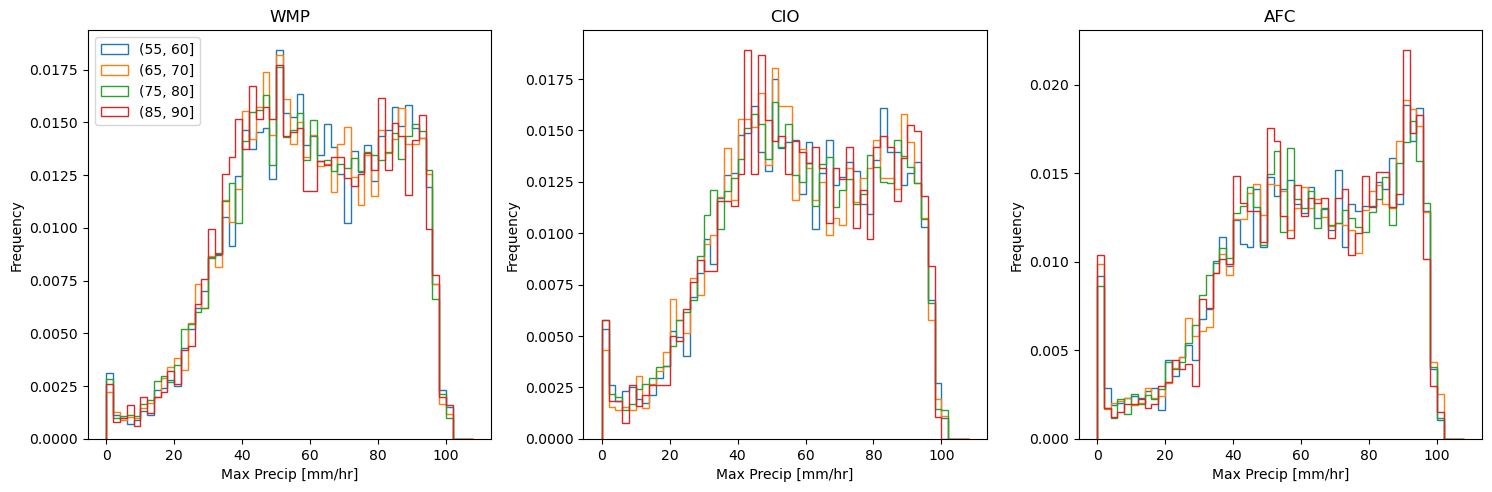

In [156]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

for region, ax in zip([wmp_region(), cio_region(), afc_region()], axs):
    pf_data = load_pf_crh(region.name)
    crh_bins = np.arange(55, 95, 5)
    pf_data['crh_binned'] = pd.cut(pf_data.crh, bins=crh_bins)
    pf_data['data_to_plot'] = 100*pf_data['num_strat_pixels']/pf_data['num_pixels']
    data_grouped = pf_data.groupby('crh_binned')['data_to_plot']


    for i, (bin_name, group_data)in enumerate(data_grouped):
        if i%2!=0:
            continue
        ax.hist(group_data, bins=np.arange(0,110, 2), alpha=1, density=True, histtype='step', label=bin_name)
        ax.set_title(f'CRH Bin: {bin_name}')
        ax.set_ylabel('Frequency')
    if ax == axs[0]:
        ax.legend(loc='upper left')
    ax.set_title(region.name)
    ax.set_xlabel('Max Precip [mm/hr]')
fig.tight_layout(pad=1)
